# Code which trains model and save it in a file

In [101]:
import pandas as pd
df = pd.read_csv("/Users/sohail21400/Desktop/trading_machine/data/EURUSD/EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")
pipdiff = 750*1e-5 #for TP
TPSLRatio = 2 #pipdiff/Ratio gives SL

In [103]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
# df.isna().sum()

Gmt time    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

## Add technical indicators here

In [104]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1, high=df['high'], low=df['low'], talib=False) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [105]:
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001947,59.946065,1.160290,1.156618,1.159121,1.167880,0.000054,-0.000132,-0.000149,-0.000162,-1.237279
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001947,58.038673,1.160920,1.156768,1.159014,1.167745,0.000090,-0.000125,-0.000145,0.000035,-0.095942
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.001965,53.777344,1.160080,1.156853,1.158880,1.167604,0.000115,-0.000123,-0.000140,0.000233,0.033494
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.001972,54.744468,1.159980,1.156944,1.158774,1.167468,0.000122,-0.000118,-0.000137,0.000164,-0.619952
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001937,57.520290,1.159965,1.157065,1.158678,1.167336,0.000117,-0.000113,-0.000136,0.000028,-0.346306


## Target category definition

In [106]:
# TODO: Understand this function

# on the fuction call, barsupfront is given as 16
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/TPSLRatio)) ):
                trendcat[line] = -1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/TPSLRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 1 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [107]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.tail()

,Gmt time,open,high,low,close,volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
28855,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001947,59.946065,1.160290,1.156618,1.159121,1.167880,0.000054,-0.000132,-0.000149,-0.000162,-1.237279,NaN
28856,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001947,58.038673,1.160920,1.156768,1.159014,1.167745,0.000090,-0.000125,-0.000145,0.000035,-0.095942,NaN
28857,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.001965,53.777344,1.160080,1.156853,1.158880,1.167604,0.000115,-0.000123,-0.000140,0.000233,0.033494,NaN
28858,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.001972,54.744468,1.159980,1.156944,1.158774,1.167468,0.000122,-0.000118,-0.000137,0.000164,-0.619952,NaN
28859,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001937,57.520290,1.159965,1.157065,1.158678,1.167336,0.000117,-0.000113,-0.000136,0.000028,-0.346306,NaN


In [108]:
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model = df_model.dropna()




attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

            ATR        RSI   Average      MA40      MA80     MA160  slopeMA40  \
165    0.004686  47.386440  1.170530  1.172736  1.176061  1.164331  -0.000036   
166    0.004764  55.656988  1.173140  1.172750  1.176156  1.164627  -0.000027   
167    0.004734  57.204264  1.176115  1.172805  1.176219  1.164922  -0.000018   
168    0.004633  53.170867  1.175325  1.172772  1.176158  1.165207  -0.000010   
169    0.004554  55.081529  1.174810  1.172729  1.176124  1.165468  -0.000010   
...         ...        ...       ...       ...       ...       ...        ...   
28837  0.001848  42.935233  1.155445  1.157715  1.162374  1.171109  -0.000059   
28838  0.001830  46.375154  1.156295  1.157628  1.162216  1.170905  -0.000075   
28839  0.001907  37.631843  1.155025  1.157479  1.162006  1.170693  -0.000098   
28840  0.001937  33.174435  1.153790  1.157292  1.161765  1.170473  -0.000121   
28841  0.001894  34.656247  1.152975  1.157129  1.161517  1.170262  -0.000141   

       slopeMA80  slopeMA16

In [109]:
from sklearn.model_selection import train_test_split
# this chooses 20% of the data for testing and 80% for training randomly
# this is not the correct way to do it, but it's a start
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [110]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
knn_model.fit(X_train, y_train)

y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

## Quick evaluation of our fitting

In [111]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 41.58%
Accuracy test: 40.20%
0.0    40.654238
2.0    30.432202
1.0    28.913560
Name: mytarget, dtype: float64
Accuracy Gambler: 32.52%


## XGBoost

In [112]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 84.0847%
****Test Results****
Accuracy: 58.8584%


## Data sampling shouldn't be random!

In [113]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

/var/folders/9j/zg2w0vvd4kd1c9dmf275gb2h0000gn/T/ipykernel_79090/3584703116.py:7: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



****Train Results****
Accuracy: 85.7561%
****Test Results****
Accuracy: 33.5835%


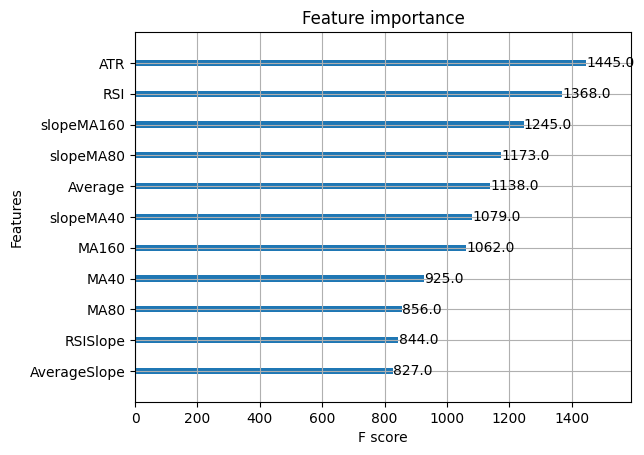

In [114]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(xgb_model)
pyplot.show()

### SAVING THE XGB MODEL INTO A FILE

In [126]:
import pickle
import xgboost as xgb

# Assuming `model` is your XGBoost model object
filename = 'xgb_model.pickle'
pickle.dump(xgb_model, open(filename, 'wb'))

### LOADING THE SAVED MODEL

In [127]:
loaded_model = pickle.load(open(filename, 'rb'))

In [121]:
len(X)

28644

In [122]:
X.iloc[28600].to_frame().T

,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
28798,0.002195,38.661931,1.15957,1.166804,1.171256,1.176846,-0.000327,-0.000283,-0.000107,0.000435,3.390087


In [128]:
loaded_model.predict(X.iloc[28600].to_frame().T)

array([0])

In [124]:
df_model['mytarget'].iloc[28600]

0.0

## PLOTING THE PREDICTED VS ACTUAL TREND VALUE

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Create some example data
actual = df_model['mytarget'].tolist()
predicted = []
for i in range(0, len(X)):
    predicted.append(loaded_model.predict(X.iloc[i].to_frame().T)[0])

actual = pd.Series(actual)
predicted = pd.Series(predicted)

# Assuming 'actual' and 'predicted' are two pandas series of equal length
df_plot = pd.concat([actual, predicted], axis=1)
df_plot.columns = ['Actual', 'Predicted']


KeyboardInterrupt: 

In [ ]:
df_plot = df_plot.iloc[0:150]

In [ ]:

# Create a list of dates to use as the x-axis
dates = [i for i in range(1, len(df_plot) + 1)]


In [ ]:
len(dates)

150

In [ ]:
len(actual)-len(predicted)

0

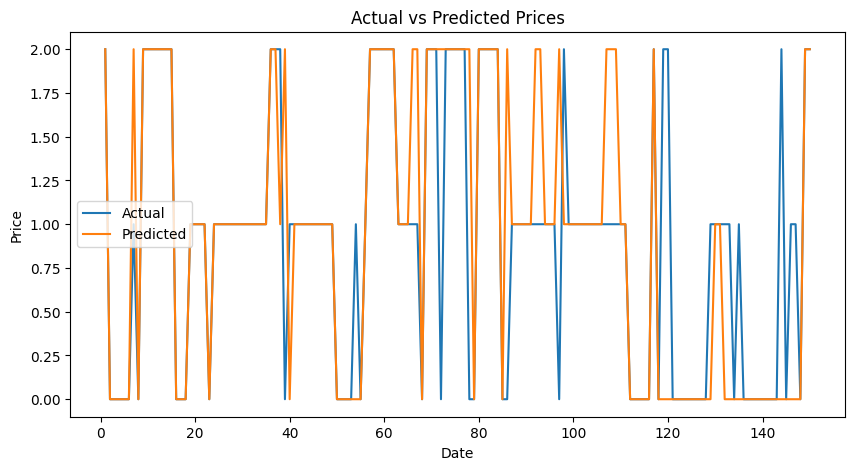

In [ ]:

# Convert index to datetime object if it's not already in datetime format
df_plot.index = dates

# Plot the time series graph
plt.figure(figsize=(10, 5))
plt.plot(df_plot['Actual'], label='Actual')
plt.plot(df_plot['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()
